In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import json, re, unicodedata, string, typing, time
import torch.nn.functional as F
import spacy
from collections import Counter
import pickle
from nltk import word_tokenize
nlp = spacy.load('en_core_web_sm')
from preprocess import *
from torch.autograd import Variable
import math
import torch.optim as optim

In [2]:
test_dataset_path = './dataset/squad_test.json'
model_path = './model/model_encoder_transformer.h5'

In [3]:
# Read preprocessed data from pickle
train_df = pd.read_pickle('./dataset/qatrain.pkl')
test_df = pd.read_pickle('./dataset/qatest.pkl')

In [4]:
weights_matrix = np.load('./dataset/qaglove_vt.npy')
word2idx = np.load('./dataset/qa_word2idx.npy', allow_pickle=True).item()
idx2word = np.load('./dataset/qa_idx2word.npy', allow_pickle=True).item()
char2idx = np.load('./dataset/qa_char2idx.npy', allow_pickle=True).item()

In [5]:
class SquadDataset:
    '''
    - Creates batches dynamically by padding to the length of largest example
      in a given batch.
    - Calulates character vectors for contexts and question.
    - Returns tensors for training.
    '''
    def __init__(self, data, batch_size):
        '''
        data: dataframe
        batch_size: int
        '''
        self.batch_size = batch_size
        data = [data[i:i+self.batch_size] for i in range(0, len(data), self.batch_size)]
        self.data = data
        
        
    def __len__(self):
        return len(self.data)
    
    def make_char_vector(self, max_sent_len, sentence, max_word_len=16):
        
        char_vec = torch.zeros(max_sent_len, max_word_len).type(torch.LongTensor)
        
        for i, word in enumerate(nlp(sentence, disable=['parser','tagger','ner'])):
            for j, ch in enumerate(word.text):
                if j == max_word_len:
                    break
                char_vec[i][j] = char2idx.get(ch, 0)
        
        return char_vec     
    
    def get_span(self, text):

        text = nlp(text, disable=['parser','tagger','ner'])
        span = [(w.idx, w.idx+len(w.text)) for w in text]

        return span

    
    def __iter__(self):
        '''
        Creates batches of data and yields them.
        
        Each yield comprises of:
        :padded_context: padded tensor of contexts for each batch 
        :padded_question: padded tensor of questions for each batch 
        :char_ctx & ques_ctx: character-level ids for context and question
        :label: start and end index wrt context_ids
        :context_text,answer_text: used while testing to calculate metrics
        :ids: question_ids for evaluation
        '''
        
        for batch in self.data:
            
            spans = []
            ctx_text = []
            answer_text = []
            
             
            for ctx in batch.context:
                ctx_text.append(ctx)
                spans.append(self.get_span(ctx))
            
            for ans in batch.answer:
                answer_text.append(ans)
                
            max_context_len = max([len(ctx) for ctx in batch.context_ids])
            padded_context = torch.LongTensor(len(batch), max_context_len).fill_(1)
            
            for i, ctx in enumerate(batch.context_ids):
                padded_context[i, :len(ctx)] = torch.LongTensor(ctx)
                
            max_word_ctx = 16
          
            char_ctx = torch.zeros(len(batch), max_context_len, max_word_ctx).type(torch.LongTensor)
            for i, context in enumerate(batch.context):
                char_ctx[i] = self.make_char_vector(max_context_len, context)
            
            max_question_len = max([len(ques) for ques in batch.question_ids])
            padded_question = torch.LongTensor(len(batch), max_question_len).fill_(1)
            
            for i, ques in enumerate(batch.question_ids):
                padded_question[i, :len(ques)] = torch.LongTensor(ques)
                
            max_word_ques = 16
            
            char_ques = torch.zeros(len(batch), max_question_len, max_word_ques).type(torch.LongTensor)
            for i, question in enumerate(batch.question):
                char_ques[i] = self.make_char_vector(max_question_len, question)
            
              
            label = torch.LongTensor(list(batch.label_idx))
            ids = list(batch.id)
            
            yield (padded_context, padded_question, char_ctx, char_ques, label, ctx_text, answer_text, ids)
            
            

In [6]:
# create dataloaders
train_dataset = SquadDataset(train_df,16)
test_dataset = SquadDataset(test_df,16)

In [7]:
class DepthwiseSeparableConvolution(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, dim=1):
        
        super().__init__()
        self.dim = dim
        if dim == 2:
            
            self.depthwise_conv = nn.Conv2d(in_channels=in_channels, out_channels=in_channels,
                                        kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2)
        
            self.pointwise_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        
    
        else:
        
            self.depthwise_conv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels,
                                            kernel_size=kernel_size, groups=in_channels, padding=kernel_size//2,
                                            bias=False)

            self.pointwise_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0, bias=True)

    
    def forward(self, x):
        # x = [bs, seq_len, emb_dim]
        if self.dim == 1:
            x = x.transpose(1,2)
            x = self.pointwise_conv(self.depthwise_conv(x))
            x = x.transpose(1,2)
        else:
            x = self.pointwise_conv(self.depthwise_conv(x))
        #print("DepthWiseConv output: ", x.shape)
        return x

In [8]:
class HighwayLayer(nn.Module):
    
    def __init__(self, layer_dim, num_layers=2):
    
        super().__init__()
        self.num_layers = num_layers
        
        self.flow_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
        self.gate_layers = nn.ModuleList([nn.Linear(layer_dim, layer_dim) for _ in range(num_layers)])
    
    def forward(self, x):
        #print("Highway input: ", x.shape)
        for i in range(self.num_layers):
            
            flow = self.flow_layers[i](x)
            gate = torch.sigmoid(self.gate_layers[i](x))
            
            x = gate * flow + (1 - gate) * x
            
        #print("Highway output: ", x.shape)
        return x

In [9]:
class EmbeddingLayer(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, kernel_size, device):
        
        super().__init__()
        
        self.device = device
        
        self.char_embedding = nn.Embedding(char_vocab_dim, char_emb_dim)
        
        self.word_embedding = self.get_glove_word_embedding()
        
        self.conv2d = DepthwiseSeparableConvolution(char_emb_dim, char_emb_dim, kernel_size,dim=2)
        
        self.highway = HighwayLayer(self.word_emb_dim + char_emb_dim)
    
        
    def get_glove_word_embedding(self):
        
        num_embeddings, embedding_dim = weights_matrix.shape
        self.word_emb_dim = embedding_dim
        embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights_matrix).to(self.device),freeze=True)

        return embedding
    
    def forward(self, x, x_char):
        # x = [bs, seq_len]
        # x_char = [bs, seq_len, word_len(=16)]
        
        word_emb = self.word_embedding(x)
        # word_emb = [bs, seq_len, word_emb_dim]
        
        word_emb = F.dropout(word_emb,p=0.1)
        
        char_emb = self.char_embedding(x_char)
        # char_embed = [bs, seq_len, word_len, char_emb_dim]
        
        char_emb = F.dropout(char_emb.permute(0,3,1,2), p=0.05)
        # [bs, char_emb_dim, seq_len, word_len] == [N, Cin, Hin, Win]
        
        conv_out = F.relu(self.conv2d(char_emb))
        # [bs, char_emb_dim, seq_len, word_len] 
        # the depthwise separable conv does not change the shape of the input
        
        char_emb, _ = torch.max(conv_out, dim=3)
        # [bs, char_emb_dim, seq_len]
        
        char_emb = char_emb.permute(0,2,1)
        # [bs, seq_len, char_emb_dim]
        
        concat_emb = torch.cat([char_emb, word_emb], dim=2)
        # [bs, seq_len, char_emb_dim + word_emb_dim]
        
        emb = self.highway(concat_emb)
        # [bs, seq_len, char_emb_dim + word_emb_dim]
        
        #print("Embedding output: ", emb.shape)
        return emb

In [10]:
class MultiheadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, num_heads, device):
        
        super().__init__()
        self.num_heads = num_heads
        self.device = device
        self.hid_dim = hid_dim
        
        self.head_dim = self.hid_dim // self.num_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, x, mask):
        # x = [bs, len_x, hid_dim]
        # mask = [bs, len_x]
        
        batch_size = x.shape[0]
        
        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)
        # Q = K = V = [bs, len_x, hid_dim]
        
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).permute(0,2,1,3)
        # [bs, len_x, num_heads, head_dim ]  => [bs, num_heads, len_x, head_dim]
        
        K = K.permute(0,1,3,2)
        # [bs, num_heads, head_dim, len_x]
        
        energy = torch.matmul(Q, K) / self.scale
        # (bs, num_heads){[len_x, head_dim] * [head_dim, len_x]} => [bs, num_heads, len_x, len_x]
        
        mask = mask.unsqueeze(1).unsqueeze(2)
        # [bs, 1, 1, len_x]
        
        #print("Mask: ", mask)
        #print("Energy: ", energy)
        
        energy = energy.masked_fill(mask == 1, -1e10)
        
        #print("energy after masking: ", energy)
        
        alpha = torch.softmax(energy, dim=-1)
        #  [bs, num_heads, len_x, len_x]
        
        #print("energy after smax: ", alpha)
        alpha = F.dropout(alpha, p=0.1)
        
        a = torch.matmul(alpha, V)
        # [bs, num_heads, len_x, head_dim]
        
        a = a.permute(0,2,1,3)
        # [bs, len_x, num_heads, hid_dim]
        
        a = a.contiguous().view(batch_size, -1, self.hid_dim)
        # [bs, len_x, hid_dim]
        
        a = self.fc_o(a)
        # [bs, len_x, hid_dim]
        
        #print("Multihead output: ", a.shape)
        return a

In [11]:
class PositionEncoder(nn.Module):
    
    def __init__(self, model_dim, device, max_length=400):
        
        super().__init__()
        
        self.device = device
        
        self.model_dim = model_dim
        
        pos_encoding = torch.zeros(max_length, model_dim)
        
        for pos in range(max_length):
            
            for i in range(0, model_dim, 2):
                
                pos_encoding[pos, i] = math.sin(pos / (10000 ** ((2*i)/model_dim)))
                pos_encoding[pos, i+1] = math.cos(pos / (10000 ** ((2*(i+1))/model_dim)))
            
        
        pos_encoding = pos_encoding.unsqueeze(0).to(device)
        self.register_buffer('pos_encoding', pos_encoding)
        
    
    def forward(self, x):
        #print("PE shape: ", self.pos_encoding.shape)
        #print("PE input: ", x.shape)
        x = x + Variable(self.pos_encoding[:, :x.shape[1]], requires_grad=False)
        #print("PE output: ", x.shape)
        return x

In [12]:
class EncoderBlock(nn.Module):
    
    def __init__(self, model_dim, num_heads, num_conv_layers, kernel_size, device):
        
        super().__init__()
        
        self.num_conv_layers = num_conv_layers
        
        self.conv_layers = nn.ModuleList([DepthwiseSeparableConvolution(model_dim, model_dim, kernel_size)
                                          for _ in range(num_conv_layers)])
        
        self.multihead_self_attn = MultiheadAttentionLayer(model_dim, num_heads, device)
        
        self.position_encoder = PositionEncoder(model_dim, device)
        
        self.pos_norm = nn.LayerNorm(model_dim)
        
        self.conv_norm = nn.ModuleList([nn.LayerNorm(model_dim) for _ in range(self.num_conv_layers)])
        
        self.feedfwd_norm = nn.LayerNorm(model_dim)
        
        self.feed_fwd = nn.Linear(model_dim, model_dim)
        
    def forward(self, x, mask):
        # x = [bs, len_x, model_dim]
        # mask = [bs, len_x]
        
        out = self.position_encoder(x)
        # [bs, len_x, model_dim]
        
        res = out
        
        out = self.pos_norm(out)
        # [bs, len_x, model_dim]
        
        for i, conv_layer in enumerate(self.conv_layers):
            
            out = F.relu(conv_layer(out))
            out = out + res
            if (i+1) % 2 == 0:
                out = F.dropout(out, p=0.1)
            res = out
            out = self.conv_norm[i](out)
        
        
        out = self.multihead_self_attn(out, mask)
        # [bs, len_x, model_dim]
        
        out = F.dropout(out + res, p=0.1)
        
        res = out
        
        out = self.feedfwd_norm(out)
        
        out = F.relu(self.feed_fwd(out))
        # [bs, len_x, model_dim]
            
        out = F.dropout(out + res, p=0.1)
        # [bs, len_x, model_dim]
        #print("Encoder block output: ", out.shape)
        return out

In [13]:
class ContextQueryAttentionLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__() 
        
        self.W0 = nn.Linear(3*model_dim, 1, bias=False)
        
    def forward(self, C, Q, c_mask, q_mask):
        # C = [bs, ctx_len, model_dim]
        # Q = [bs, qtn_len, model_dim]
        # c_mask = [bs, ctx_len]
        # q_mask = [bs, qtn_len]
        
        c_mask = c_mask.unsqueeze(2)
        # [bs, ctx_len, 1]
        
        q_mask = q_mask.unsqueeze(1)
        # [bs, 1, qtn_len]
        
        ctx_len = C.shape[1]
        qtn_len = Q.shape[1]
        
        C_ = C.unsqueeze(2).repeat(1,1,qtn_len,1)
        # [bs, ctx_len, qtn_len, model_dim] 
        
        Q_ = Q.unsqueeze(1).repeat(1,ctx_len,1,1)
        # [bs, ctx_len, qtn_len, model_dim]
        
        C_elemwise_Q = torch.mul(C_, Q_)
        # [bs, ctx_len, qtn_len, model_dim]
        
        S = torch.cat([C_, Q_, C_elemwise_Q], dim=3)
        # [bs, ctx_len, qtn_len, model_dim*3]
        
        S = self.W0(S).squeeze()
        #print("Simi matrix: ", S.shape)
        # [bs, ctx_len, qtn_len, 1] => # [bs, ctx_len, qtn_len]
        
        S_row = S.masked_fill(q_mask==1, -1e10)
        S_row = F.softmax(S_row, dim=2)
        
        S_col = S.masked_fill(c_mask==1, -1e10)
        S_col = F.softmax(S_col, dim=1)
        
        A = torch.bmm(S_row, Q)
        # (bs)[ctx_len, qtn_len] X [qtn_len, model_dim] => [bs, ctx_len, model_dim]
        
        B = torch.bmm(torch.bmm(S_row,S_col.transpose(1,2)), C)
        # [ctx_len, qtn_len] X [qtn_len, ctx_len] => [bs, ctx_len, ctx_len]
        # [ctx_len, ctx_len] X [ctx_len, model_dim ] => [bs, ctx_len, model_dim]
        
        model_out = torch.cat([C, A, torch.mul(C,A), torch.mul(C,B)], dim=2)
        # [bs, ctx_len, model_dim*4]
        
        #print("C2Q output: ", model_out.shape)
        return F.dropout(model_out, p=0.1)
        
        

In [14]:
class OutputLayer(nn.Module):
    
    def __init__(self, model_dim):
        
        super().__init__()
        
        self.W1 = nn.Linear(2*model_dim, 1, bias=False)
        
        self.W2 = nn.Linear(2*model_dim, 1, bias=False)
        
        
    def forward(self, M1, M2, M3, c_mask):
        
        start = torch.cat([M1,M2], dim=2)
        
        start = self.W1(start).squeeze()
        
        p1 = start.masked_fill(c_mask==1, -1e10)
        
        #p1 = F.log_softmax(start.masked_fill(c_mask==1, -1e10), dim=1)
        
        end = torch.cat([M1, M3], dim=2)
        
        end = self.W2(end).squeeze()
        
        p2 = end.masked_fill(c_mask==1, -1e10)
        
        #p2 = F.log_softmax(end.masked_fill(c_mask==1, -1e10), dim=1)
        
        #print("preds: ", [p1.shape,p2.shape])
        return p1, p2
        

In [15]:
class EncoderTransformer(nn.Module):
    
    def __init__(self, char_vocab_dim, char_emb_dim, word_emb_dim, kernel_size, model_dim, num_heads, device):
        
        super().__init__()
        
        self.embedding = EmbeddingLayer(char_vocab_dim, char_emb_dim, kernel_size, device)
        
        self.ctx_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.qtn_resizer = DepthwiseSeparableConvolution(char_emb_dim+word_emb_dim, model_dim, 5)
        
        self.embedding_encoder = EncoderBlock(model_dim, num_heads, 4, 5, device)
        
        self.c2q_attention = ContextQueryAttentionLayer(model_dim)
        
        self.c2q_resizer = DepthwiseSeparableConvolution(model_dim*4, model_dim, 5)
        
        self.model_encoder_layers = nn.ModuleList([EncoderBlock(model_dim, num_heads, 2, 5, device)
                                                   for _ in range(7)])
        
        self.output = OutputLayer(model_dim)
        
        self.device=device
    
    def forward(self, ctx, qtn, ctx_char, qtn_char):
        
        c_mask = torch.eq(ctx, 1).float().to(self.device)
        q_mask = torch.eq(qtn, 1).float().to(self.device)
        
        ctx_emb = self.embedding(ctx, ctx_char)
        # [bs, ctx_len, ch_emb_dim + word_emb_dim]
        
        ctx_emb = self.ctx_resizer(ctx_emb)
        #  [bs, ctx_len, model_dim]
        
        qtn_emb = self.embedding(qtn, qtn_char)
        # [bs, ctx_len, ch_emb_dim + word_emb_dim]
        
        qtn_emb = self.qtn_resizer(qtn_emb)
        # [bs, qtn_len, model_dim]
        
        C = self.embedding_encoder(ctx_emb, c_mask)
        # [bs, ctx_len, model_dim]
        
        Q = self.embedding_encoder(qtn_emb, q_mask)
        # [bs, qtn_len, model_dim]
            
        C2Q = self.c2q_attention(C, Q, c_mask, q_mask)
        # [bs, ctx_len, model_dim*4]
        
        M1 = self.c2q_resizer(C2Q)
        # [bs, ctx_len, model_dim]
    
        for layer in self.model_encoder_layers:
            M1 = layer(M1, c_mask)
        
        M2 = M1
        # [bs, ctx_len, model_dim]  
        
        for layer in self.model_encoder_layers:
            M2 = layer(M2, c_mask)
        
        M3 = M2
        # [bs, ctx_len, model_dim]
        
        for layer in self.model_encoder_layers:
            M3 = layer(M3, c_mask)
            
        p1, p2 = self.output(M1, M2, M3, c_mask)
        
        return p1, p2

In [16]:
CHAR_VOCAB_DIM = len(char2idx)
CHAR_EMB_DIM = 200
WORD_EMB_DIM = 300
KERNEL_SIZE = 5
MODEL_DIM = 128
NUM_ATTENTION_HEADS = 8
device = torch.device('cuda')

model = EncoderTransformer(CHAR_VOCAB_DIM,
              CHAR_EMB_DIM, 
              WORD_EMB_DIM,
              KERNEL_SIZE,
              MODEL_DIM,
              NUM_ATTENTION_HEADS,
              device).to(device)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,274,096 trainable parameters


In [18]:
optimizer = optim.Adam(model.parameters(), betas=(0.8,0.999), eps=10e-7, weight_decay=3*10e-7)

In [19]:
def train(model, train_dataset):
    print("Starting training ........")
   

    train_loss = 0.
    batch_count = 0
    predictions = {}
    for batch in train_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch: {batch_count}")
        batch_count += 1
        
        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch
        
        # place data on GPU
        context, question, char_ctx, char_ques, label = context.to(device), question.to(device),\
                                    char_ctx.to(device), char_ques.to(device), label.to(device)
        
        # forward pass, get predictions
        preds = model(context, question, char_ctx, char_ques)

        start_pred, end_pred = preds
        
        # separate labels for start and end position
        start_label, end_label = label[:,0], label[:,1]
        
        # calculate loss
        loss = F.cross_entropy(start_pred, start_label) + F.cross_entropy(end_pred, end_label)
        
        # backward pass
        loss.backward()
        
        # update the gradients
        optimizer.step()

        # zero the gradients so that they do not accumulate
        optimizer.zero_grad()

        train_loss += loss.item()
        
        batch_size, c_len = start_pred.size()
        ls = nn.LogSoftmax(dim=1)
        mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
        score = (ls(start_pred).unsqueeze(2) + ls(end_pred).unsqueeze(1)) + mask
        score, s_idx = score.max(dim=1)
        score, e_idx = score.max(dim=1)
        s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()


        for i in range(batch_size):
            id = ids[i]
            pred = context[i][s_idx[i]:e_idx[i]+1]
            pred = ' '.join([idx2word[idx.item()] for idx in pred])
            predictions[id] = pred        
    
    em, f1 = evaluate(predictions, "train")
    return train_loss/len(train_dataset), em, f1

In [20]:
def test(model, test_dataset):
    
    print("Starting testing .........")
   
    test_loss = 0.

    batch_count = 0
    
    f1, em = 0., 0.
    
    predictions = {}
    
    for batch in test_dataset:

        if batch_count % 500 == 0:
            print(f"Starting batch {batch_count}")
        batch_count += 1

        context, question, char_ctx, char_ques, label, ctx_text, ans, ids = batch

        context, question, char_ctx, char_ques, label = context.to(device), question.to(device),\
                                    char_ctx.to(device), char_ques.to(device), label.to(device)

        with torch.no_grad():

            preds = model(context, question, char_ctx, char_ques)

            p1, p2 = preds

            y1, y2 = label[:,0], label[:,1]

            loss = F.nll_loss(p1, y1) + F.nll_loss(p2, y2)

            test_loss += loss.item()

            batch_size, c_len = p1.size()
            ls = nn.LogSoftmax(dim=1)
            mask = (torch.ones(c_len, c_len) * float('-inf')).to(device).tril(-1).unsqueeze(0).expand(batch_size, -1, -1)
            score = (ls(p1).unsqueeze(2) + ls(p2).unsqueeze(1)) + mask
            score, s_idx = score.max(dim=1)
            score, e_idx = score.max(dim=1)
            s_idx = torch.gather(s_idx, 1, e_idx.view(-1, 1)).squeeze()
            
           
            for i in range(batch_size):
                id = ids[i]
                pred = context[i][s_idx[i]:e_idx[i]+1]
                pred = ' '.join([idx2word[idx.item()] for idx in pred])
                predictions[id] = pred
            
    em, f1 = evaluate(predictions, "test")
    return test_loss/len(test_dataset), em, f1           
  

In [21]:
with open('./dataset/squad_test.json','r',encoding='utf-8') as f:
    test_ds = json.load(f)['data']
with open('./dataset/squad_train.json','r',encoding='utf-8') as f:
    train_ds = json.load(f)['data']

In [22]:
def evaluate(predictions, stage):
    '''
    Gets a dictionary of predictions with question_id as key
    and prediction as value. The testing dataset has multiple 
    answers for a single question. Hence we compare our prediction
    with all the answers and choose the one that gives us
    the maximum metric (em or f1). 
    This method first parses the JSON file, gets all the answers
    for a given id and then passes the list of answers and the 
    predictions to calculate em, f1.
    
    
    :param dict predictions
    Returns
    : exact_match: 1 if the prediction and ground truth 
      match exactly, 0 otherwise.
    : f1_score: 
    '''
    if stage == "train":
        dataset = train_ds
    else:
        dataset = test_ds
    
    f1 = exact_match = total = 0
    for article in dataset:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                total += 1
                if qa['id'] not in predictions:
                    continue
                
                ground_truths = list(map(lambda x: x['text'], qa['answers']))
                
                prediction = predictions[qa['id']]
                
                exact_match += metric_max_over_ground_truths(
                    exact_match_score, prediction, ground_truths)
                
                f1 += metric_max_over_ground_truths(
                    f1_score, prediction, ground_truths)
                
    
    exact_match = 100.0 * exact_match / total
    f1 = 100.0 * f1 / total
    
    return exact_match, f1



In [23]:
def normalize_answer(s):
    '''
    Performs a series of cleaning steps on the ground truth and 
    predicted answer.
    '''
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    Returns maximum value of metrics for predicition by model against
    multiple ground truths.
    
    :param func metric_fn: can be 'exact_match_score' or 'f1_score'
    :param str prediction: predicted answer span by the model
    :param list ground_truths: list of ground truths against which
                               metrics are calculated. Maximum values of 
                               metrics are chosen.
                            
    
    '''
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
        
    return max(scores_for_ground_truths)


def f1_score(prediction, ground_truth):
    '''
    Returns f1 score of two strings.
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    Returns exact_match_score of two strings.
    '''
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

def epoch_time(start_time, end_time):
    '''
    Helper function to record epoch time.
    '''
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [24]:
train_losses = []
test_losses = []
train_ems = []
train_f1s = []
test_ems = []
test_f1s = []
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}")
    
    start_time = time.time()
    
    train_loss, train_em, train_f1 = train(model, train_dataset)
    test_loss, test_em, test_f1 = test(model, test_dataset)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_ems.append(train_em)
    train_f1s.append(train_f1)
    test_ems.append(test_em)
    test_f1s.append(test_f1)
    
    print(f"Epoch train loss : {train_loss} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Epoch test loss: {test_loss}")
    print(f"Epoch train EM: {train_em} | test EM: {test_em}")
    print(f"Epoch train F1: {train_f1} | test F1: {test_f1}")
    print("====================================================================================")

Epoch 1
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting batch: 3000
Starting batch: 3500
Starting batch: 4000
Starting batch: 4500
Starting batch: 5000
Starting testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Starting batch 1500
Starting batch 2000
Epoch train loss : 8.814281854610076 | Time: 52m 6s
Epoch test loss: -0.587448033911587
Epoch train EM: 5.075400404114202 | test EM: 11.542100283822139
Epoch train F1: 13.035519904127579 | test F1: 20.567152731669996
Epoch 2
Starting training ........
Starting batch: 0
Starting batch: 500
Starting batch: 1000
Starting batch: 1500
Starting batch: 2000
Starting batch: 2500
Starting batch: 3000
Starting batch: 3500
Starting batch: 4000
Starting batch: 4500
Starting batch: 5000
Starting testing .........
Starting batch 0
Starting batch 500
Starting batch 1000
Starting batch 1500
Starting batch 2000
Epoch train l

In [25]:
# Save model
torch.save(model.state_dict(), model_path)

In [27]:
CHAR_VOCAB_DIM = len(char2idx)
CHAR_EMB_DIM = 200
WORD_EMB_DIM = 300
KERNEL_SIZE = 5
MODEL_DIM = 128
NUM_ATTENTION_HEADS = 8
device = torch.device('cuda')

model = EncoderTransformer(CHAR_VOCAB_DIM,
              CHAR_EMB_DIM, 
              WORD_EMB_DIM,
              KERNEL_SIZE,
              MODEL_DIM,
              NUM_ATTENTION_HEADS,
              device).to(device)

model.load_state_dict(torch.load(model_path))
model.eval()

EncoderTransformer(
  (embedding): EmbeddingLayer(
    (char_embedding): Embedding(232, 200)
    (word_embedding): Embedding(110474, 300)
    (conv2d): DepthwiseSeparableConvolution(
      (depthwise_conv): Conv2d(200, 200, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=200)
      (pointwise_conv): Conv2d(200, 200, kernel_size=(1, 1), stride=(1, 1))
    )
    (highway): HighwayLayer(
      (flow_layers): ModuleList(
        (0): Linear(in_features=500, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=500, bias=True)
      )
      (gate_layers): ModuleList(
        (0): Linear(in_features=500, out_features=500, bias=True)
        (1): Linear(in_features=500, out_features=500, bias=True)
      )
    )
  )
  (ctx_resizer): DepthwiseSeparableConvolution(
    (depthwise_conv): Conv1d(500, 500, kernel_size=(5,), stride=(1,), padding=(2,), groups=500, bias=False)
    (pointwise_conv): Conv1d(500, 128, kernel_size=(1,), stride=(1,))
  )
  (qtn_resizer):

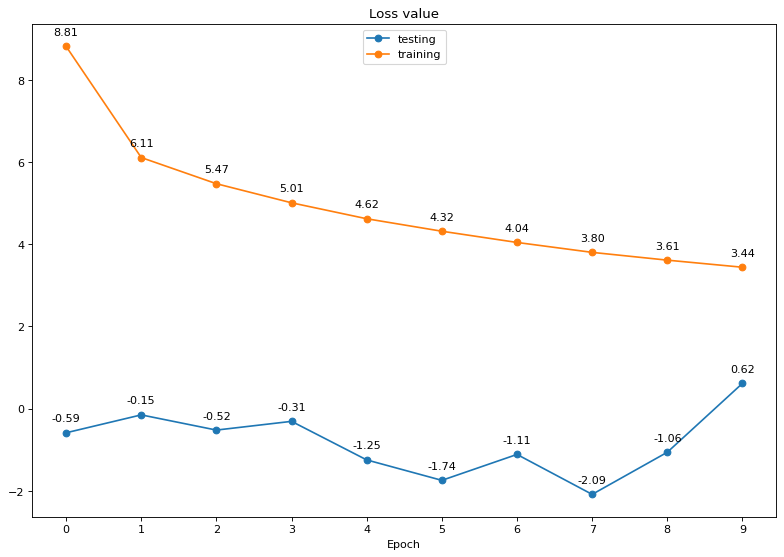

In [27]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_losses, label="testing", marker='o')
x=0
for y in test_losses:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_losses,label="training", marker='o')
x=0
for y in train_losses:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,10))
plt.title('Loss value',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()

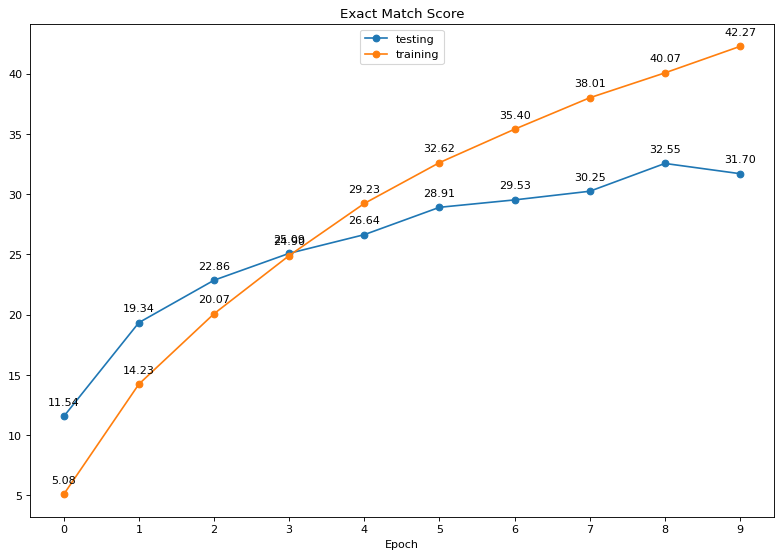

In [28]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_ems, label="testing", marker='o')
x=0
for y in test_ems:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_ems,label="training", marker='o')
x=0
for y in train_ems:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,10))
plt.title('Exact Match Score',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()

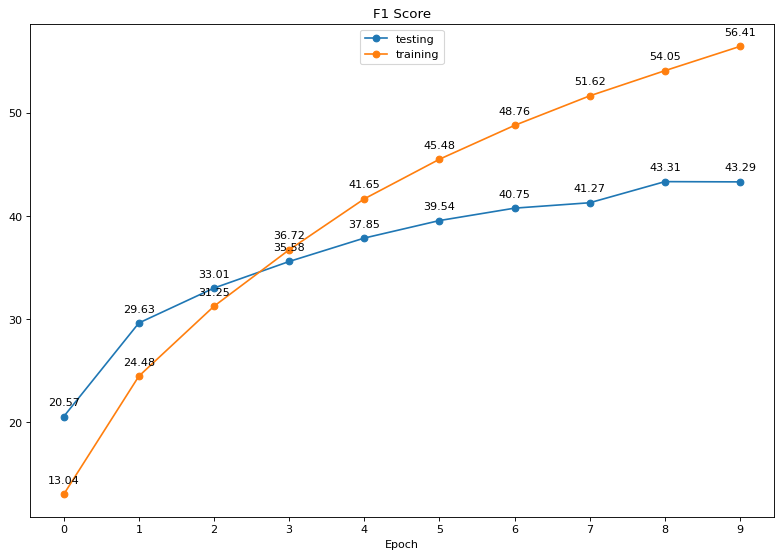

In [29]:
plt.figure(figsize=(12, 8), dpi=80)
# plt.subplot(211)
plt.plot(test_f1s, label="testing", marker='o')
x=0
for y in test_f1s:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1

plt.plot(train_f1s,label="training", marker='o')
x=0
for y in train_f1s:
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    x=x+1
# plt.yticks([0.10,0.30,0.50,0.70])
plt.xticks(range(0,10))
plt.title('F1 Score',fontsize=12)
plt.xlabel('Epoch', fontsize=10)
plt.legend(loc='upper center')
# ax.legend()
plt.show()